Running on the Aer simulator 
=============================

In this two-part tutorial, we demonstrate the process of executing a simple quantum chemical computation using 'shot' based sampling and on noisy quantum emulators and hardware.

Since this tutorial is focused on practical quantum computation, we will perform a straightforward calculation: the single-point evaluation of the total energy for the H2 molecule using the Unitary Coupled Cluster (UCC) ansatz, without optimization or parameter variance. 

This is the first part of this tutorial, and for the second part we examine the use of a [Quantinuum hardware emulator](InQ_htut_Hser_H2.ipynb). The use of IBM hardware (and emulator) is also possible, but note that this requires an IBM Quantum account and the appropriate credentials to run on a machine with at least four qubits for a brief duration. Please refer to [this page](setup_ibm.rst) for instructions on how to set up calculations on IBM Quantum's devices.

The outlined steps are as follows:

Notebook 1

- Define the system 
- Perform noise-free simulation (AerStateBackend)
- Perform stochastic simulation (AerBackend)
- Perform simulation with simple noisy simulation of the quantum computation (AerBackend + custom noise profile)

Notebook 2

- Redefine the system
- Perform computation with emulated hardware noise (QuantinuumBackend emulator + machine noise profile)
- Demonstrate error mitigation methods on emulated hardware (PMSV)



### 0. System preparation
To begin, we use the `express` module to load in the converged mean-field (Hartree-Fock) spin-orbitals, potential, and Hamiltonian from a calculation of H2 using the STO-3G basis set. 


In [ ]:
from inquanto.express import load_h5

h2 = load_h5("h2_sto3g.h5", as_tuple=True)
hamiltonian = h2.hamiltonian_operator

Now we prepare the Fermionic space and define the Fermionic state. 

The space here is defined with 4 spin-orbitals (which matches the full H2 STO-3G space) and we use the D2h point group.

This point group is the most practical high symmetry group to approximate the $\text{D} \infty \text{h}$ group. We also explicitly define the orbital symmetries.

The state is then set by the ground state occupations [1,1,0,0] and the Hamiltonian encoded from the Hartree-Fock 
integrals. 

A space of excited states is then created using the UCCSD ansatz, which is then mapped to a quantum circuit using Jordan-Wigner (JW) encoding. InQuanto uses an efficient ansatz circuit compilation approach here, provided by the `FermionSpaceStateExpJWChemicallyAware` class, to reduce the computational resources required.


In [ ]:
from inquanto.spaces import FermionSpace
from inquanto.states import FermionState
from inquanto.symmetry import PointGroup
from inquanto.ansatzes import FermionSpaceStateExpChemicallyAware

space = FermionSpace(
    4, point_group=PointGroup("D2h"), orb_irreps=["Ag", "Ag", "B1u", "B1u"]
)

state = FermionState([1, 1, 0, 0])
qubit_hamiltonian = hamiltonian.qubit_encode()

exponents = space.construct_single_ucc_operators(state)
## the above adds nothing due to the symmetry of the system
exponents += space.construct_double_ucc_operators(state)
ansatz = FermionSpaceStateExpChemicallyAware(exponents, state)

The ansatz circuit structure is well-defined, but the guess for the wave function parameters (weights of the exponentiated determinants / angles of rotation gates) has not been established. These parameters are initialized with a single value denoted as 'p', detailed below. 

Once the parameters are defined, the `Computable` class is employed to specify the quantity of interest: we seek to evaluate the expectation value of the Hamiltonian for a given parameter value $\theta$, $E=\langle \Psi(\theta)|\hat{H} |\Psi(\theta)\rangle$.

For demonstration purposes, we fix the random seed on the initialization of the parameters using `seed=6`, which should set a parameter value of 0.499675. Alternatively, this parameter can be set using `p = ansatz.state_symbols.construct_from_array([0.4996755931358105])`.

In [ ]:
# p = ansatz.state_symbols.construct_random(seed=6)
p = ansatz.state_symbols.construct_from_array([0.4996755931358105])
print(p)

from inquanto.computables import ExpectationValue

expectation0 = ExpectationValue(ansatz, hamiltonian.qubit_encode())

   ordering symbol     value
0         0     d0  0.499676


With the circuit and parameters now established, it becomes possible to display and analyze the circuit. This particular circuit comprises 4 qubits and consists of 31 gates. Notably, among these gates, the multi-qubit CNOT gates, are expected to contribute the most noise. In this circuit, there are a total of 4 CNOT gates.

In [ ]:
from pytket.circuit.display import render_circuit_jupyter

render_circuit_jupyter(ansatz.get_circuit(p))

from pytket import Circuit, OpType

print("\n2-qubit GATES:  {}".format(ansatz.circuit_resources()['gates_2q']))

print(ansatz.state_circuit)


CNOT GATES:  4
<tket::Circuit, qubits=4, gates=31>


We are now ready to think about how we run this circuit. 

To better comprehend the impact of noise on computing this circuit, in the following cell, we establish a set of "shots" to scan over, along with a random seed number and various other parameters. To illustrate the varying degrees of stochasticity and quantum noise across different backends, we will present convergence plots. These plots will demonstrate how the average energy converges towards the expectation value with increasing sampling. 

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (12, 4)

set_shots = [10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000]
# N_shots * N_measured_terms is the total number of shots
# n_shots arg is number of samples per commuting set formed from the Hamiltonian terms
set_seed = 1

### 1. Noiseless Statevector simulation

The evaluation of a quantum measurement can be carried out directly by state vector methods, which perform the linear algebra of gate operations directly to an explicit $2^N$ dimensional representation of the quantum state. This method returns the computable of the system directly without considering the stochasticity of the quantum measurements at the end of the circuit. Note that statevector backends do not take number of shots as an arguemnt. The needed resultant probability amplitudes are returned directly rather than averaged over sampling the computational basis eigenvalues. For the given system parameter ($\theta =  0.499676$), we expect an energy of $-0.587646$ Ha.

In general, to define where the computation is performed we set the backend, in this case `backend = AerStateBackend()` .

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

from pytket.extensions.qiskit import AerStateBackend
from inquanto.computables import ExpectationValue
from inquanto.protocols import BackendStatevectorProtocol

backend = AerStateBackend()

expval_expression = ExpectationValue(ansatz, hamiltonian.qubit_encode())
protocol = BackendStatevectorProtocol(backend)
evaluator = protocol.get_evaluator(p)
statevector_energy = expval_expression.evaluate(evaluator=evaluator)

shotless_energies = [statevector_energy,] * len(
    set_shots
)  # for plotting later

print("Statevector energy is " + str(np.real(statevector_energy)) + "Ha")

Statevector energy is -0.5876463677224998Ha


### 2. Noiseless simulation

Subsequently, we proceed to simulate "shots", representing the runs of the quantum computer, using the `AerBackend`. This simulation, devoid of quantum noise such as decoherence during processing, does incorporate the stochastic nature of measuring the system, culminating in a probabilistic collapse into a computational basis state upon simulation completion. Each individual shot yields a measurement outcome of 0 or 1 on each qubit. By accumulating numerous shots, one can estimate the expectation value of each Pauli string within the Hamiltonian. Higher shot counts lead to increased precision in these expectation values, ultimately resulting in enhanced precision of the overall Hamiltonian expectation value.

We generate a plot to illustrate the convergence of energy concerning the number of shots. This plot reveals that with approximately 1000 shots, the averaging of the system reaches a sufficient level, closely resembling the results obtained from the AerStateBackend (within a margin of 0.01 Ha).

We recommend changing the seed value in `protocol.run()` to examine different convergence regimes. Consider what number of shots is required for consistent precision. 

In [ ]:
from pytket.extensions.qiskit import AerBackend
from inquanto.protocols import PauliAveraging
from pytket.partition import PauliPartitionStrat

backend = []
backend = AerBackend()

protocol_template = PauliAveraging(
    backend,
    shots_per_circuit=10,
    pauli_partition_strategy=PauliPartitionStrat.CommutingSets,
)
protocol_template.build(p, ansatz, hamiltonian.qubit_encode()).compile_circuits()

protocol_pickle = protocol_template.dumps()

In [ ]:
noiseless_energies = []
for i in set_shots:
    protocol = PauliAveraging.loads(protocol_pickle, backend)
    protocol.shots_per_circuit = i
    protocol.run(seed=set_seed)
    aer_expectation = protocol.evaluate_expectation_value(
        ansatz, hamiltonian.qubit_encode()
    )
    noiseless_energies.append(aer_expectation)

-0.5848319000310379


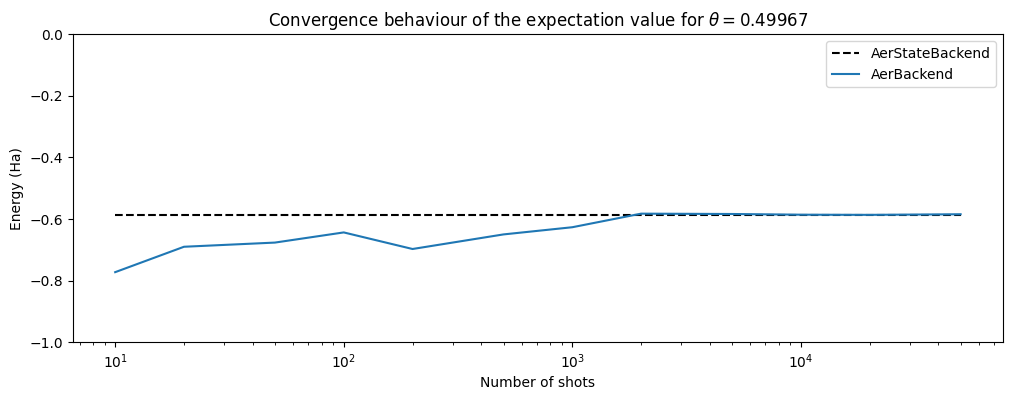

In [ ]:
plt.plot(set_shots, shotless_energies, label="AerStateBackend", color="black", ls="--")
plt.plot(set_shots, noiseless_energies, label="AerBackend")
plt.xscale("log")
plt.ylim([-1, 0])
plt.xlabel("Number of shots")
plt.ylabel("Energy (Ha)")
plt.title(
    "Convergence behavior of the expectation value for "
    + r"$\theta=$%.5f" % list(p.values())[0]
)
plt.legend()

print(noiseless_energies[-1])

### 3. Simple quantum noise model

Having demonstrated the stochastic nature of quantum measurement, we are ready to consider quantum noise. 

To do this, first we will use a simple quantum noise model. The noise in quantum circuits can manifest in many ways. A simple noise model is constructed by adding depolarising error to CNOT gates. This can be a reasonable first approximation to multi-qubit operations which generally cause the most quantum noise. 

There are many other types of quantum noise that can be added, some of which are detailed in the [Qiskit documentation](https://qiskit.org/documentation/aer/stubs/qiskit_aer.noise.NoiseModel.html). One other simple example is the readout error, which represents incorrectly measuring the qubit state at the end of the circuit.

We recommend modifying the `cnot_error_rate` parameter and also the seed number in `noisy_aer_expectation.run()`.  In particular, consider whether for larger CNOT error rate (>0.01) the system does or does not practically converge to the AerStateBackend result.



In [ ]:
## In this cell we define the noise model
from qiskit_aer.noise import NoiseModel  # , ReadoutError
import qiskit_aer.noise as noise


cnot_error_rate = 0.01
noise_model = NoiseModel()
error_1 = noise.depolarizing_error(cnot_error_rate, 2)

n_qubits = 4
for qubit in range(n_qubits):
    for qubit2 in (x for x in range(n_qubits) if x != qubit):
        noise_model.add_quantum_error(error_1, ["cx"], [qubit, qubit2])

print(noise_model.is_ideal())  ## this reports false if there is noise in the model

False


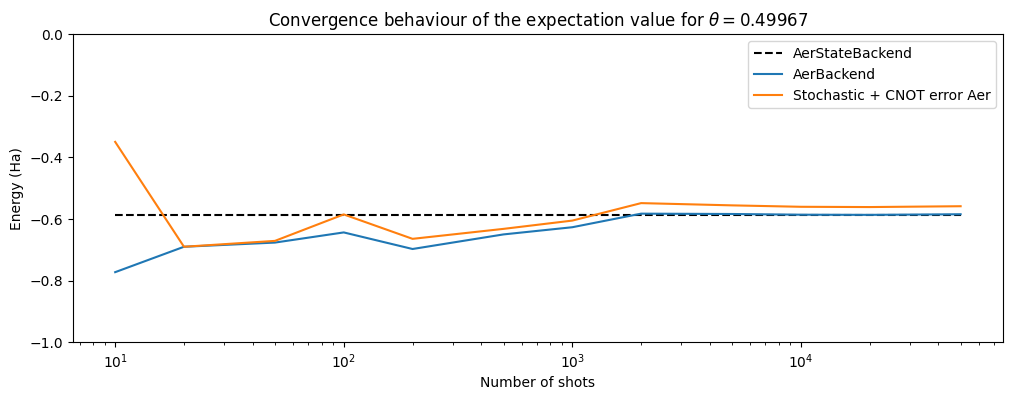

In [ ]:
## This cell runs the cnot noisy simulation

noisy_backend = AerBackend(
    noise_model=noise_model
)  # this defaults to no noise, which is the same as NoiseModel.is_ideal
noisy_energies = []

# rebuild protocol/circuits for new noisy backend
protocol_template = PauliAveraging(
    noisy_backend,
    shots_per_circuit=10,
    pauli_partition_strategy=PauliPartitionStrat.CommutingSets,
)
protocol_template.build(p, ansatz, hamiltonian.qubit_encode()).compile_circuits()
protocol_pickle = protocol_template.dumps()

for i in set_shots:
    protocol = PauliAveraging.loads(protocol_pickle, noisy_backend)
    protocol.shots_per_circuit = i
    protocol.run(seed=set_seed)
    aer_expectation = protocol.evaluate_expectation_value(
        ansatz, hamiltonian.qubit_encode()
    )
    noisy_energies.append(aer_expectation)

plt.plot(set_shots, shotless_energies, label="AerStateBackend", color="black", ls="--")
plt.plot(set_shots, noiseless_energies, label="AerBackend")
plt.plot(set_shots, noisy_energies, label="Stochastic + CNOT error Aer")
plt.xscale("log")
plt.ylim([-1, 0])
plt.xlabel("Number of shots")
plt.ylabel("Energy (Ha)")
plt.title(
    "Convergence behavior of the expectation value for "
    + r"$\theta=$%.5f" % list(p.values())[0]
)
plt.legend()

The final plot shows that noisy operations lead to a shift in the total expectation value due to biasing. Increasing the number of shots should increase precision but not accuracy without the use of error mitigation methods. 

This tutorial has demonstrated the use of freely available Qiskit backends to evaluate a simple quantum system. The final example adds a simple model of quantum noise. 

This is the first part of this tutorial, and for the second part we examine the use of a [Quantinuum hardware emulator](InQ_htut_Hser_H2.ipynb) involving a more complex and realistic noise model, and the use of noise mitigation.